# Modena house prices regression
#### A ML Regression model to predict house prices in the Modena Province (Italy) relying on house sales websites data

This notebook was developed as part of the hand-on personal projects of IBM Machine Learning Professionnal Certificate course.

The dataset used in this analysis was retrieved from the following link: https://www.kaggle.com/datasets/albertostefani/modena-housing-price  
Data available under CC0: Public Domain license.

Further information were added about the city geospatial coordinates that were found at: https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name   
Gespatial dataset was available under CC BY 4.0 DEED license.

#### Research question:
Is it possible to predict houses' sale price through regression only by using online available data?
#### Structure of the research:
To answer this question, a research was conducted using a publicly available dataset about listed houses in the Modena province in July 2023 on a popular house sales websites. After some data exploration and cleaning, several regreession models are developed: Simple Linear Regression model, Polynomial Regression model, Ridge Regression model and Lasso Regression model. Finally, from the resulting model performance it is decided which one is the most appropriate and from its performance coclusions will be taken.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
from statsmodels.stats.weightstats import ztest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error


In [2]:
filename = 'modena_housing_data.csv'
data = pd.read_csv(filename, index_col=0)
data.head()

,code,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,energetic_class,year,city,zone,date,price
0,96752978,flat,68.0,1,1,0,0,False,False,False,False,True,M,G,1970.0,Bastiglia,Via San Martino,2023-07-26,82.000
1,103619684,flat,92.0,1,2,1,1,False,False,False,False,True,M,NaN,1971.0,Bastiglia,via verdi,2023-07-26,85.000
2,103604470,flat,80.0,1,2,1,1,True,False,True,True,True,M,NaN,2007.0,Bastiglia,Via Del Riccio,2023-07-26,133.000
3,104929507,flat,110.0,1,2,1,1,False,False,True,True,True,M,NaN,1965.0,Bastiglia,via XXV Aprile,2023-07-26,145.000
4,103619638,flat,75.0,1,2,1,1,False,False,True,True,True,M,NaN,1998.0,Bastiglia,Via delle macine,2023-07-26,128.000


## Dataset description

**Modena housing dataset**: This is the main dataset of the analysis. Data was collected by the author of the dataset through web-scraping of a popular online housing website. We have a total of 20 columns representing the features and 4092 listed houses. Data was collected in date 26-07-2023.  
\
Below the list of the features and their description: 

| FEATURE NAME | FEATURE DESCRIPTION |
|--------------|---------------------|
| **code**     | Unique identifier of the listed house |
| **type**     | House type: flat, townhouse, house, penthouse, rustic, farmhous| 
| **m2**       | Total square meters of the property |
| **bathrooms**| Number of bathrooms |
| **bedrooms** |  Number of bedrooms |
| **private_parking**     | Number of parking lots in private garage that belong to the property |
| **common_parking**     | Number of parking lots in common parking/garage that belong to the property |
| **elevator**     |  Elevator presence True/False |
| **private_garden**     | Private garden presence True/False |
| **common_garden**     | Unique identifier of the listed house |
| **balcony**     | Balcony presence True/False |
| **autonomous_heating**     | Is heating system autonomous? True/False |
| **heating_type** | M = methane, G = gas, S = solar, P = heat pump |
| **energetic_class**     | Energetic cathegory classification |
| **year**     | House's construction year |
| **city**     | City where the property is located |
| **zone**     | Specific address or zone of the city |
| **date**     | Date of data collection |
| **price**    | Listed price of the property |

**geonames dataset**: This dataset will be used during the exploratory data analysis and it collects geospatial coordinates for living areas with more than 1000 citizens, along with other data. Since in this notebook only a restriced number of features will be used, an in depth description is not provided. More info at the link above.


## Exploratory Data Analysis
Let's exlore the dataset in order to better understand how to use it develop a regression model that can help us predict house prices in the Modena province.  
\
During the following EDA data quality will be checked in terms of missing values, outliers and alignment with the purpose of the research. Every cathegorical feature is checked in order to understand its values and perform some cleaning/simplification of the dataset. In addition, cities will be converted to their geografical coordinate. This was done to try to preserve the information about the house position without having to deal with an excessive amount of variables after the one-hot-encoding phase.   
\
Once the dataset is clean, some visualizations will be drawn to gain insights about data, and try to predict which features will influence the model the most. Particular focus will be on the "common_garden" and "private_garden" variables, where hypothesis testing is going to be used to test whether having a garden positively influences the sale price or not.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092 entries, 0 to 4091
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   code                4092 non-null   int64  
 1   type                4092 non-null   object 
 2   m2                  4088 non-null   float64
 3   bathrooms           4092 non-null   object 
 4   bedrooms            4092 non-null   object 
 5   private_parking     4092 non-null   int64  
 6   common_parking      4092 non-null   int64  
 7   elevator            4092 non-null   bool   
 8   private_garden      4092 non-null   bool   
 9   common_garden       4092 non-null   bool   
 10  balcony             4092 non-null   bool   
 11  autonomous_heating  4092 non-null   bool   
 12  heating_type        4092 non-null   object 
 13  energetic_class     2963 non-null   object 
 14  year                4092 non-null   float64
 15  city                4092 non-null   object 
 16  zone  

There are some categorical features, that we'll later need to deal with. First let's check for duplicates and clean the dataset a little...

In [4]:
duplicates = data[data[['code']].duplicated()]
duplicates

,code,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,energetic_class,year,city,zone,date,price


There seems to be no duplicates in the data, so we can drop the "code" column.

In [5]:
data.drop(columns='code', inplace=True)

Also the "zone" column is too specific for the analysis since it collects, sometimes not completly, the street address.  
Moreover, we can also drop the "date" column because data was all collected in the same time period.

In [6]:
data.drop(columns=['zone','date'],inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092 entries, 0 to 4091
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                4092 non-null   object 
 1   m2                  4088 non-null   float64
 2   bathrooms           4092 non-null   object 
 3   bedrooms            4092 non-null   object 
 4   private_parking     4092 non-null   int64  
 5   common_parking      4092 non-null   int64  
 6   elevator            4092 non-null   bool   
 7   private_garden      4092 non-null   bool   
 8   common_garden       4092 non-null   bool   
 9   balcony             4092 non-null   bool   
 10  autonomous_heating  4092 non-null   bool   
 11  heating_type        4092 non-null   object 
 12  energetic_class     2963 non-null   object 
 13  year                4092 non-null   float64
 14  city                4092 non-null   object 
 15  price               3854 non-null   object 
dtypes: boo

Let's check the missing values...

In [8]:
null = data.isnull().sum().sort_values(ascending=False)
null

energetic_class       1129
price                  238
m2                       4
type                     0
bathrooms                0
bedrooms                 0
private_parking          0
common_parking           0
elevator                 0
private_garden           0
common_garden            0
balcony                  0
autonomous_heating       0
heating_type             0
year                     0
city                     0
dtype: int64

Since we need to use the price as dependent variable we cannot use the lines where this is not present. The simpler solution is to drop those lines.

In [9]:
data.dropna(axis=0,subset=['price'],inplace=True)
data.reset_index(drop=True,inplace=True)

Last to features with missing values we need to deal with are "energetic_class" and "m2". 
- **energetic_class**: Since almost 30% of the information is missing, replacing missing data with arbitrary values could be too risky. At the same time, dropping the rows with missing data would mean to drop 30% of the dataset. So, we'll drop the feature itself leaving the rest of the dataset for the analysis.   
- **m2**: just 4 values are missing, it could be a good solution to replace them with the mean for the corresponding housetype.  

In [10]:
data.drop(columns='energetic_class', inplace=True)


In [11]:
data[data['m2'].isnull()==True]

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,city,price
1240,flat,NaN,a,a,0,0,True,False,False,False,True,M,2009.0,Fiorano Modenese,170.000
1245,flat,NaN,1,2,1,0,True,False,True,True,True,M,1975.0,Fiorano Modenese,180.000
2233,house,NaN,3,5,1,1,False,True,False,True,True,M,1930.0,Modena,750.000
3454,townhouse,NaN,2,3,2,0,False,True,False,True,True,M,1930.0,Savignano sul Panaro,65.000


In [12]:
data.groupby(['type'])['m2'].mean()

type
farmhous     391.835000
flat         112.995551
house        261.220993
penthouse    171.000000
rustic       278.833164
townhouse    218.416149
Name: m2, dtype: float64

In [13]:
data.loc[1240,'m2'] = 113
data.loc[1245,'m2'] = 113
data.loc[2233,'m2'] = 261
data.loc[3454,'m2'] = 218


In [14]:
data.isnull().sum()

type                  0
m2                    0
bathrooms             0
bedrooms              0
private_parking       0
common_parking        0
elevator              0
private_garden        0
common_garden         0
balcony               0
autonomous_heating    0
heating_type          0
year                  0
city                  0
price                 0
dtype: int64

Let's now examine cathegorical data...

In [15]:
data.dtypes

type                   object
m2                    float64
bathrooms              object
bedrooms               object
private_parking         int64
common_parking          int64
elevator                 bool
private_garden           bool
common_garden            bool
balcony                  bool
autonomous_heating       bool
heating_type           object
year                  float64
city                   object
price                  object
dtype: object

In [16]:
#first let's take 'price' to float type
for i, item in enumerate(data['price']):
    data.loc[i,'price'] = data.loc[i,'price'].replace('.','')
    data.loc[i,'price'] = data.loc[i,'price'].replace(',','.')
data[['price']] = data[['price']].astype(float)

In [17]:
data.loc[13,'price']

176062.0

In [18]:
data.dtypes

type                   object
m2                    float64
bathrooms              object
bedrooms               object
private_parking         int64
common_parking          int64
elevator                 bool
private_garden           bool
common_garden            bool
balcony                  bool
autonomous_heating       bool
heating_type           object
year                  float64
city                   object
price                 float64
dtype: object

In the following lines of code cathegorical variables will be "adjusted" to increase their significance or to deal with some possible data collection errors...

In [19]:
mask = data.dtypes != float
cat_cols = data.columns[mask]
print(cat_cols)

Index(['type', 'bathrooms', 'bedrooms', 'private_parking', 'common_parking',
       'elevator', 'private_garden', 'common_garden', 'balcony',
       'autonomous_heating', 'heating_type', 'city'],
      dtype='object')


In [20]:
data['type'].value_counts()

flat         2584
house         742
townhouse     323
penthouse     144
rustic         55
farmhous        6
Name: type, dtype: int64

In [21]:
#since cathegories like "house", "rustic", and "farmhouse" are very similar, we join them as "house"
data['type'] = np.where(data['type']=='rustic', 'house', data['type'])
data['type'] = np.where(data['type']=='farmhous', 'house', data['type'])
data['type'].value_counts()

flat         2584
house         803
townhouse     323
penthouse     144
Name: type, dtype: int64

In [22]:
data['bathrooms'].value_counts()

1    1763
2    1470
3     389
4     190
i      18
u      11
a       7
s       5
n       1
Name: bathrooms, dtype: int64

In [23]:
data['bedrooms'].value_counts()

2    1555
3    1314
1     343
4     311
5     135
6      80
g      22
i      21
7      18
8      16
u      11
9      10
a       7
0       6
s       2
t       2
n       1
Name: bedrooms, dtype: int64

In [24]:
#let'd delete the lines where the number of bathrooms and bedrooms were not registered appropriately
data['bedrooms'] = np.where((data['bedrooms'] == 'g') |
                            (data['bedrooms'] == 'i') |
                            (data['bedrooms'] == 'u') |
                            (data['bedrooms'] == 'a') |
                            (data['bedrooms'] == 's') |
                            (data['bedrooms'] == 't') |
                            (data['bedrooms'] == 'n') |
                            (data['bedrooms'] == '0'), 
                            np.nan, data['bedrooms'])
data['bathrooms'] = np.where((data['bathrooms'] == 'i') |
                            (data['bathrooms'] == 'u') |
                            (data['bathrooms'] == 'a') |
                            (data['bathrooms'] == 's') |
                            (data['bathrooms'] == 'n'),
                            np.nan, data['bedrooms'])
data.dropna(axis=0,subset=['bedrooms','bathrooms'],inplace=True)

#we can now convert the featurs to int type
data[['bedrooms']] = data[['bedrooms']].astype(int)
data[['bathrooms']] = data[['bathrooms']].astype(int)

In [25]:
data['private_parking'].value_counts()

1    2108
0     979
2     670
Name: private_parking, dtype: int64

In [26]:
data['common_parking'].value_counts()

0    1941
1    1216
2     401
3      90
4      65
5      22
6       9
8       6
7       5
9       2
Name: common_parking, dtype: int64

In [27]:
data['elevator'].value_counts()

False    2475
True     1282
Name: elevator, dtype: int64

In [28]:
data['private_garden'].value_counts()

False    2368
True     1389
Name: private_garden, dtype: int64

In [29]:
data['common_garden'].value_counts()

False    2690
True     1067
Name: common_garden, dtype: int64

In [30]:
data['balcony'].value_counts()

True     2226
False    1531
Name: balcony, dtype: int64

In [31]:
data['autonomous_heating'].value_counts()

True     3200
False     557
Name: autonomous_heating, dtype: int64

In [32]:
data['heating_type'].value_counts()

M    2567
G     810
S     192
P     188
Name: heating_type, dtype: int64

In [33]:
#aggregating gas and methane
data['heating_type'] = np.where(data['heating_type']=='M', 'G', data['heating_type'])

In [34]:
data['city'].value_counts()

Modena                     1011
Carpi                       562
Sassuolo                    209
Castelfranco Emilia         194
Formigine                   133
Vignola                     115
Nonantola                   113
Soliera                     103
San Prospero                 97
Castelnuovo Rangone          93
Mirandola                    85
San Felice sul Panaro        63
Finale Emilia                54
Pavullo nel Frignano         53
Bomporto                     51
Castelvetro di Modena        51
Spilamberto                  50
Ravarino                     50
Maranello                    49
Novi di Modena               48
Savignano sul Panaro         47
Concordia sulla Secchia      45
Serramazzoni                 45
Guiglia                      44
Fiorano Modenese             37
Sestola                      34
Fanano                       33
Cavezzo                      31
Marano sul Panaro            29
Medolla                      28
Campogalliano                27
San Cesa

Managing city areas as cathegorical values would lead to an excessive amount of features during the one-hot-encoding phase. To still keep track of the city feature we could try to save the city coordinates.  
We'll check during model development phase if this is actually useful or we can just not consider the house location inside the Modena province.

In [35]:
#loading geospatial data and keeping only coordinates of Italian cities in Modena Province
filename = 'geonames-all-cities-with-a-population-1000.csv'
geo = pd.read_csv(filename, sep=';')
geo = geo[geo['Country name EN']=='Italy']
geo = geo[geo['Admin2 Code']=='MO']
geo = geo.loc[:,['Name','Coordinates']]
geo

,Name,Coordinates
320,Pavullo nel Frignano,"44.33352, 10.83544"
383,Finale Emilia,"44.83373, 11.29378"
11856,Formigine,"44.57268, 10.84737"
11993,Mulino,"44.49257, 11.04667"
20366,Rovereto,"44.83381, 10.95157"
...,...,...
139019,San Prospero,"44.78967, 11.0221"
145172,Savignano sul Panaro,"44.48036, 11.0351"
145203,Prignano sulla Secchia,"44.43836, 10.6919"
145260,Lama,"44.30726, 10.7306"


In [36]:
#joining dataframes and checking for possible missing coordinates
data = data.join(geo.set_index('Name'), on='city')
data[['Coordinates']].isnull().sum()

Coordinates    606
dtype: int64

In [37]:
data

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,city,price,Coordinates
0,flat,68.0,1,1,0,0,False,False,False,False,True,G,1970.0,Bastiglia,82000.0,"44.72697, 10.9986"
1,flat,92.0,2,2,1,1,False,False,False,False,True,G,1971.0,Bastiglia,85000.0,"44.72697, 10.9986"
2,flat,80.0,2,2,1,1,True,False,True,True,True,G,2007.0,Bastiglia,133000.0,"44.72697, 10.9986"
3,flat,110.0,2,2,1,1,False,False,True,True,True,G,1965.0,Bastiglia,145000.0,"44.72697, 10.9986"
4,flat,75.0,2,2,1,1,False,False,True,True,True,G,1998.0,Bastiglia,128000.0,"44.72697, 10.9986"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849,flat,71.0,2,2,0,0,False,True,False,False,True,G,1992.0,Zocca,96000.0,"44.34566, 10.99308"
3850,flat,76.0,2,2,1,0,False,True,False,False,True,G,1994.0,Zocca,90000.0,"44.34566, 10.99308"
3851,flat,48.0,1,1,1,0,False,True,False,True,True,G,1980.0,Zocca,39000.0,"44.34566, 10.99308"
3852,townhouse,307.0,6,6,0,4,False,True,False,False,True,G,1975.0,Zocca,185000.0,"44.34566, 10.99308"


In [38]:
#manually adding missing coordinates 
data['Coordinates'] = np.where(data['city']=='Carpi', '44.78237, 10.8777', data['Coordinates'])
data['Coordinates'] = np.where(data['city']=='Fiorano Modenese', '44.53889, 10.81166', data['Coordinates'])
data['Coordinates'] = np.where(data['city']=='Fiumalbo', '44.17925, 10.6472', data['Coordinates'])
data['Coordinates'] = np.where(data['city']=='Lama Mocogno', '44.30726, 10.7306', data['Coordinates'])

In [39]:
#splitting Latitude and Longitude
data[['Lat','Long']] = data['Coordinates'].str.split(', ',expand=True)
#dropping 'Coordinates' and 'city' columns
data.drop(columns='Coordinates',inplace=True)
data.drop(columns='city',inplace=True)
#casting float type
data[['Lat']] = data[['Lat']].astype(float)
data[['Long']] = data[['Long']].astype(float)

In [40]:
data

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,price,Lat,Long
0,flat,68.0,1,1,0,0,False,False,False,False,True,G,1970.0,82000.0,44.72697,10.99860
1,flat,92.0,2,2,1,1,False,False,False,False,True,G,1971.0,85000.0,44.72697,10.99860
2,flat,80.0,2,2,1,1,True,False,True,True,True,G,2007.0,133000.0,44.72697,10.99860
3,flat,110.0,2,2,1,1,False,False,True,True,True,G,1965.0,145000.0,44.72697,10.99860
4,flat,75.0,2,2,1,1,False,False,True,True,True,G,1998.0,128000.0,44.72697,10.99860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849,flat,71.0,2,2,0,0,False,True,False,False,True,G,1992.0,96000.0,44.34566,10.99308
3850,flat,76.0,2,2,1,0,False,True,False,False,True,G,1994.0,90000.0,44.34566,10.99308
3851,flat,48.0,1,1,1,0,False,True,False,True,True,G,1980.0,39000.0,44.34566,10.99308
3852,townhouse,307.0,6,6,0,4,False,True,False,False,True,G,1975.0,185000.0,44.34566,10.99308


In [41]:
data.dtypes

type                   object
m2                    float64
bathrooms               int64
bedrooms                int64
private_parking         int64
common_parking          int64
elevator                 bool
private_garden           bool
common_garden            bool
balcony                  bool
autonomous_heating       bool
heating_type           object
year                  float64
price                 float64
Lat                   float64
Long                  float64
dtype: object

The dataset is almost ready to be analyzed. First let's try to draw some insight from the data as-is.

In [42]:
data.describe().round(3)

,m2,bathrooms,bedrooms,private_parking,common_parking,year,price,Lat,Long
count,3757.000,3757.000,3757.000,3757.000,3757.000,3757.000,3757.000,3757.000,3757.000
mean,153.646,2.680,2.680,0.918,0.749,1979.294,255257.618,44.647,10.937
std,103.794,1.168,1.168,0.657,1.061,47.794,184279.470,0.143,0.098
min,1.000,1.000,1.000,0.000,0.000,1069.000,13921.000,44.179,10.571
25%,91.000,2.000,2.000,0.000,0.000,1967.000,135000.000,44.549,10.878
50%,120.000,2.000,2.000,1.000,0.000,1980.000,201000.000,44.648,10.925
75%,180.000,3.000,3.000,1.000,1.000,2005.000,325000.000,44.782,11.011
max,954.000,9.000,9.000,2.000,9.000,2025.000,3200000.000,44.913,11.294


We need to inspect why there seem to be some records with very little surface "m2".

In [43]:
data.sort_values(by='m2').head(30)

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,price,Lat,Long
393,flat,1.000,3,3,1,0,False,False,True,True,True,G,1975.0,139000.0,44.78237,10.87770
1341,townhouse,1.000,3,3,0,2,False,True,False,True,True,G,1960.0,268000.0,44.57268,10.84737
1398,house,1.000,1,1,0,0,False,False,False,False,True,G,1980.0,56954.0,44.42432,10.96125
3165,house,1.013,5,5,0,0,False,True,False,True,True,G,1970.0,360000.0,44.78967,11.02210
456,house,1.025,4,4,0,3,False,True,False,False,True,G,2016.0,820000.0,44.78237,10.87770
1021,house,1.060,2,2,2,1,False,True,False,True,True,G,1967.0,450000.0,44.50422,10.94666
1431,house,1.077,3,3,0,0,False,False,False,False,True,G,1980.0,42188.0,44.30726,10.73060
2339,house,1.100,5,5,1,0,False,True,False,False,True,G,1900.0,360000.0,44.64783,10.92539
270,house,1.100,5,5,1,0,False,True,False,False,True,G,1700.0,1200000.0,44.78237,10.87770
2221,house,1.200,6,6,2,0,False,True,False,True,True,G,1978.0,365000.0,44.64783,10.92539


Since for some reason, during data collection, some houses were assigned a surfacee of less than 3 $m^2$, we clean the dataset by removing these record.  
To be safe let's delete all records with less than 25 $m^2$.

In [44]:
wrong_m2 = data[data['m2']<=25].index
data.drop(wrong_m2,inplace=True)
data.reset_index(drop=True,inplace=True)

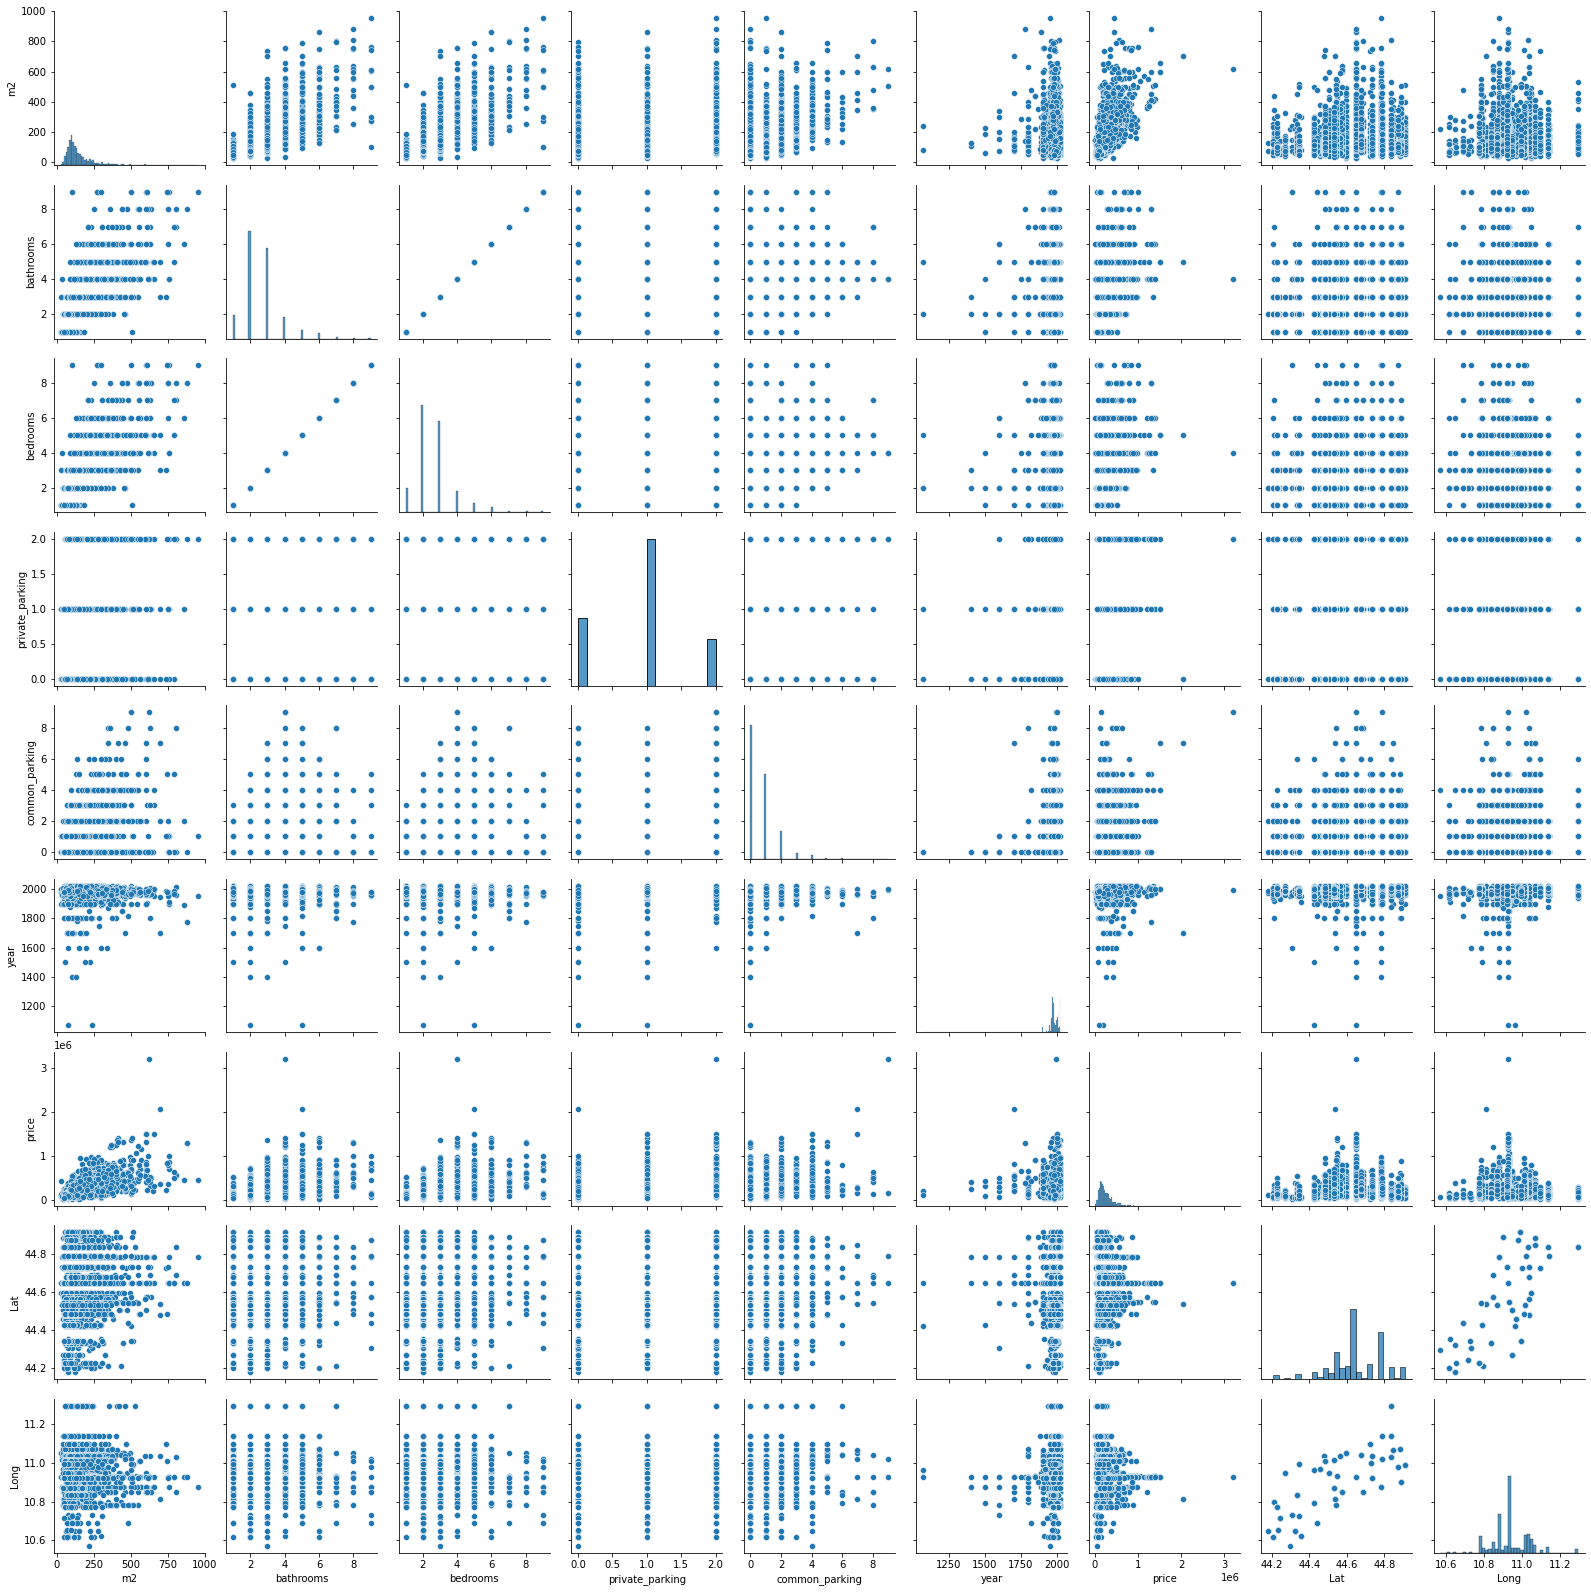

In [45]:
#pairplot for numeric variables
sns.pairplot(data=data[['m2','bathrooms','bedrooms','private_parking','common_parking','year','price','Lat','Long']])
plt.show()

Let's check for outliers in float columns...

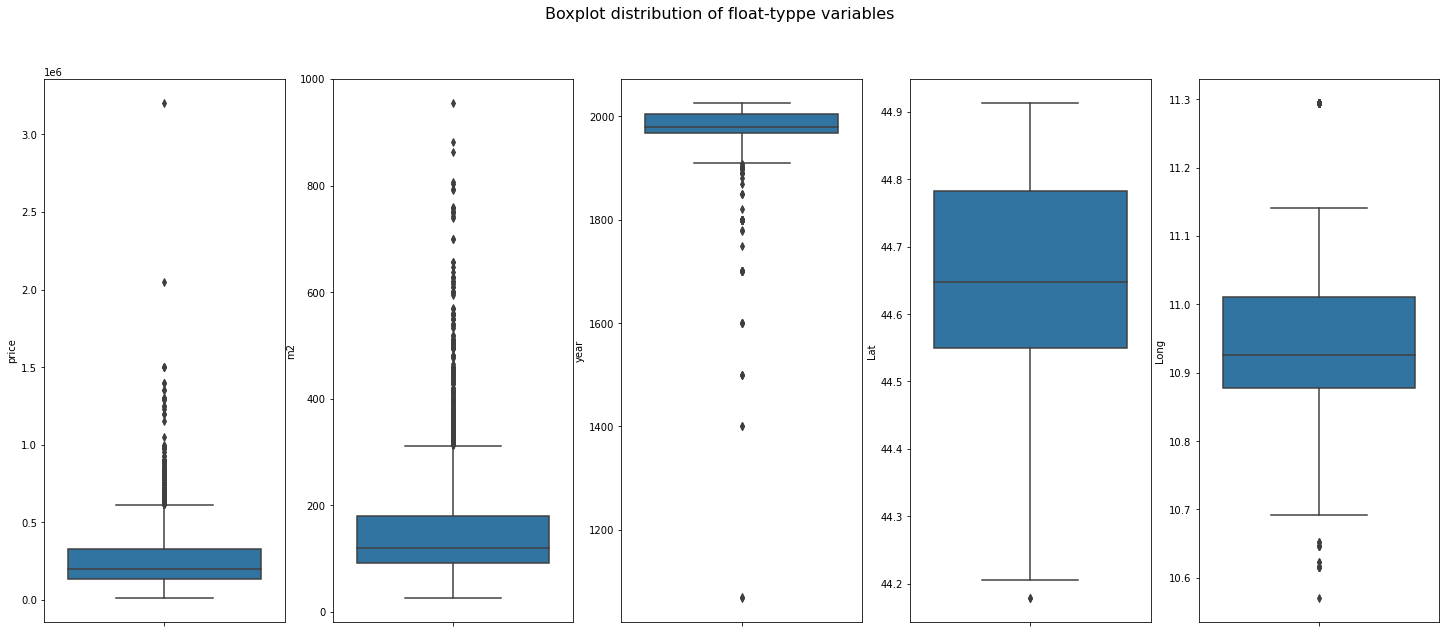

In [46]:
float_vars = data[['price','m2','year','Lat','Long']].columns

fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(25, 10),sharey=False)
for i, ax in enumerate(axs):
    sns.boxplot(ax=ax, data=data, y=float_vars[i])
    ax.set_ylabel(float_vars[i])

fig.suptitle('Boxplot distribution of float-typpe variables', fontsize=16)

plt.show()

Among the possible outliers, some in particular can be noticed that could particularly mislead the model in the 'price' and 'year' features.    
- **outliers in year**. Given that some particular properties are particularly old and probably historical they should be modeled with different parameters from the ones used for standard homes. So the decision is to delete records for year < 1600
- **outliers in price**. Two particular outliers can be detected. The decision is to remove them.

It was decided to remove these outliers because the dataset does not include features like the house condition (new, recently restored, to be restored etc.) and classification (luxury, popular, etc.). These factor could be strictly tied with price and years features helping to explain outliers. Since this kind of info is absent it was decided to drop the outliers to develop a simpler model.

In [47]:
out_year = data[data['year']<=1600].index
out_price = data.sort_values(['price'], ascending=False).head(2).index

out_list = list(set(list(out_year)+list(out_price)))

data.drop(out_list,inplace=True)
data.reset_index(drop=True,inplace=True)

In [48]:
data

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,price,Lat,Long
0,flat,68.0,1,1,0,0,False,False,False,False,True,G,1970.0,82000.0,44.72697,10.99860
1,flat,92.0,2,2,1,1,False,False,False,False,True,G,1971.0,85000.0,44.72697,10.99860
2,flat,80.0,2,2,1,1,True,False,True,True,True,G,2007.0,133000.0,44.72697,10.99860
3,flat,110.0,2,2,1,1,False,False,True,True,True,G,1965.0,145000.0,44.72697,10.99860
4,flat,75.0,2,2,1,1,False,False,True,True,True,G,1998.0,128000.0,44.72697,10.99860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,flat,71.0,2,2,0,0,False,True,False,False,True,G,1992.0,96000.0,44.34566,10.99308
3715,flat,76.0,2,2,1,0,False,True,False,False,True,G,1994.0,90000.0,44.34566,10.99308
3716,flat,48.0,1,1,1,0,False,True,False,True,True,G,1980.0,39000.0,44.34566,10.99308
3717,townhouse,307.0,6,6,0,4,False,True,False,False,True,G,1975.0,185000.0,44.34566,10.99308


Let's check some relationships between cathegorical data and house sale price...

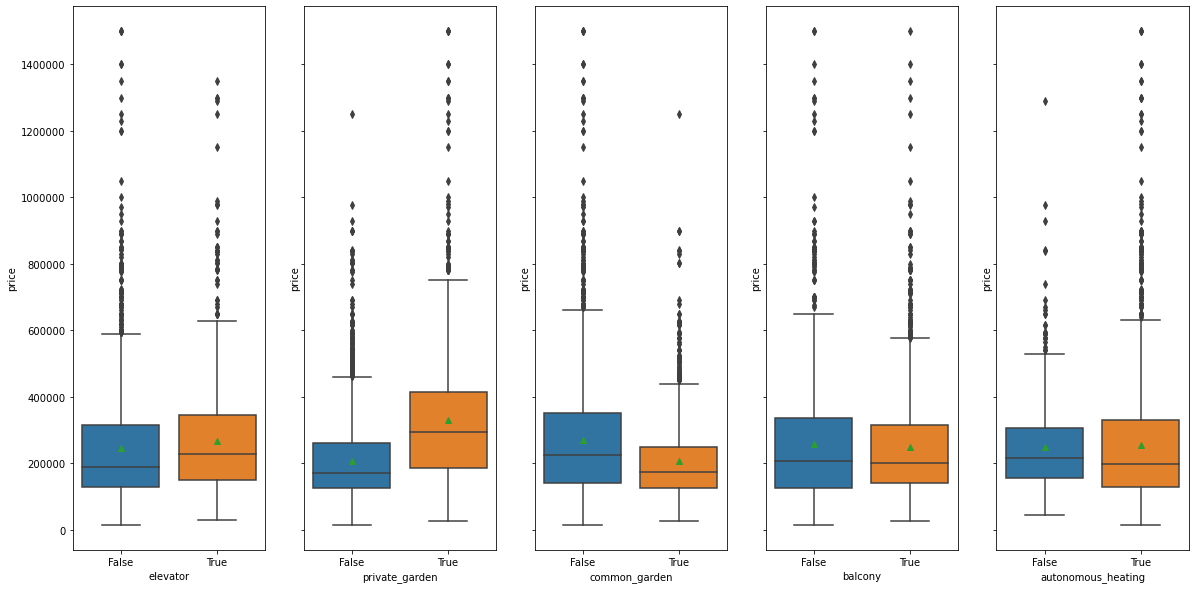

In [49]:
x_vars = data[['elevator','private_garden','common_garden','balcony','autonomous_heating']].columns

fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(20, 10),sharey=True)
for i, ax in enumerate(axs):
    sns.boxplot(ax=ax, data=data, x=x_vars[i],y='price',  showmeans=True)
    ax.ticklabel_format(axis='y', style='plain')

From the above graph we can notice:
1. As one could expect, having a private garden positively affects the house price;
2. Houses with common garden areas tend be worth less on average. Further research could be made on this.

These and other insights could be tested with statisical significance tests. For example let's suppose we want to test if the difference in the average house price respect to "common_gardens"=True/False is statistical significant.  
We can use a Z-score test. Null hypothesis is that the means of the two populations are the same. Let's calaculate the p-value supposing $\alpha$=0.05.

In [50]:
sample1 = data[data['common_garden']==True]['price'].values
sample2 = data[data['common_garden']==False]['price'].values

sample_mean1 = np.mean(sample1)
sample_mean2 = np.mean(sample2)
sample_size1 = len(sample1)
sample_size2 = len(sample2)

z,p = ztest(x1=sample1,x2=sample2,value=0)
print('Z-score:',z,'\nP-value:',p)

Z-score: -10.211882972896124 
P-value: 1.7542690616829485e-24


The p-value is very low (less than $\alpha$), so we can reject the null hypothesis that the two populations have the same mean value, since the propbability that this is given by random events is very low. We can conclude that on avearge, in the Modena province, houses with common gardens are worth less than houses without it.   
\
Does this says that having a common garden negatively affects the sale price?  
\
No, this could be due to the fact actually a big number of the listed properties has a private garden (raising the average price of houses with common_garden=False). To understand this, it is useful to compare price distribution for houses with no garden at all vs. houses with common garden and with private garden separately.

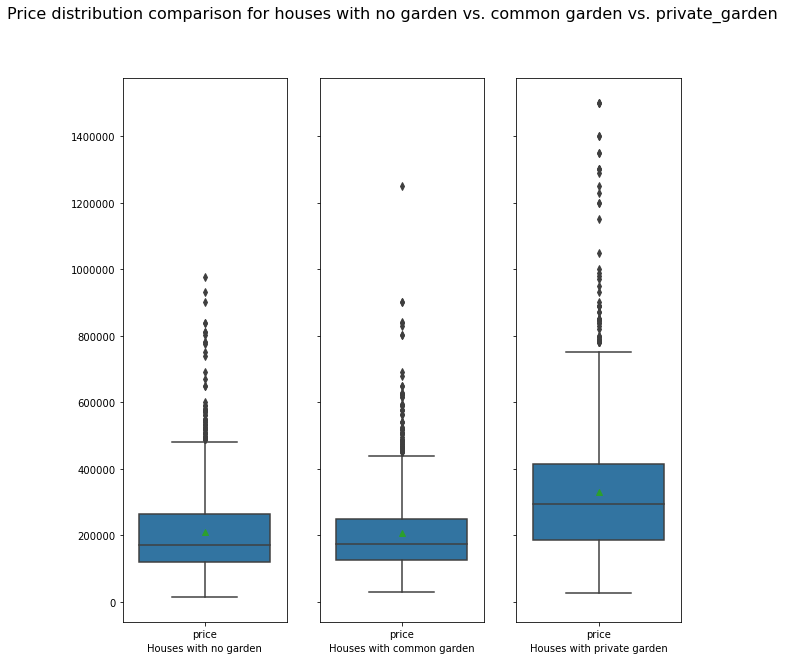

Average price for houses with no garden: 208809.73953488373
Average price for houses with common garden: 207661.69896519286
Average price for houses with private garden: 330450.31698389456


In [51]:
query_1 = data[(data['common_garden']==False) & (data['private_garden']==False)][['price']]
query_2 = data[(data['common_garden']==True) & (data['private_garden']==False)][['price']]
query_3 = data[(data['common_garden']==False) & (data['private_garden']==True)][['price']]

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(10, 10),sharey=True)

sns.boxplot(ax=axs[0], data=query_1, showmeans=True)
axs[0].set_xlabel('Houses with no garden')
axs[0].ticklabel_format(axis='y', style='plain')
sns.boxplot(ax=axs[1], data=query_2, showmeans=True)
axs[1].set_xlabel('Houses with common garden')
axs[1].ticklabel_format(axis='y', style='plain')
sns.boxplot(ax=axs[2], data=query_3, showmeans=True)
axs[2].set_xlabel('Houses with private garden')
axs[2].ticklabel_format(axis='y', style='plain')

fig.suptitle('Price distribution comparison for houses with no garden vs. common garden vs. private_garden', fontsize=16)

plt.show()

no_garden_mean = query_1['price'].mean()
common_garden_mean = query_2['price'].mean()
private_garden_mean = query_3['price'].mean()

print('Average price for houses with no garden:',no_garden_mean)
print('Average price for houses with common garden:',common_garden_mean)
print('Average price for houses with private garden:',private_garden_mean)

It can be noticed that common gardens on average do not influence the average price respect to having no garden at all. We can test this hypothesis to conclude:

In [52]:
sample1 = query_1['price'].values
sample2 = query_2['price'].values

sample_mean1 = np.mean(sample1)
sample_mean2 = np.mean(sample2)
sample_size1 = len(sample1)
sample_size2 = len(sample2)

z,p = ztest(x1=sample1,x2=sample2,value=0)
print('Z-score:',z,'\nP-value:',p)

Z-score: 0.21043420892889994 
P-value: 0.83332879548074


In this case the p-value is well above the .05 threshold. This means that the null hypothesis of the two populations having the same mean cannot be rejected.  
To conclude, the same test can be performed comparing mean price values for houses with private garden and no garden at all:  

In [53]:
sample1 = query_1['price'].values
sample2 = query_3['price'].values

sample_mean1 = np.mean(sample1)
sample_mean2 = np.mean(sample2)
sample_size1 = len(sample1)
sample_size2 = len(sample2)

z,p = ztest(x1=sample1,x2=sample2,value=0)
print('Z-score:',z,'\nP-value:',p)

Z-score: -17.80363910656798 
P-value: 6.622243952801606e-71


It can be concluded that having a garden positively influences the price only if it is a private one.
Next feature to check against price is "type". Is the sale price dependent on the house type?   
\
It can be seen below that, as one could imagine, the house type does influence the sale price.

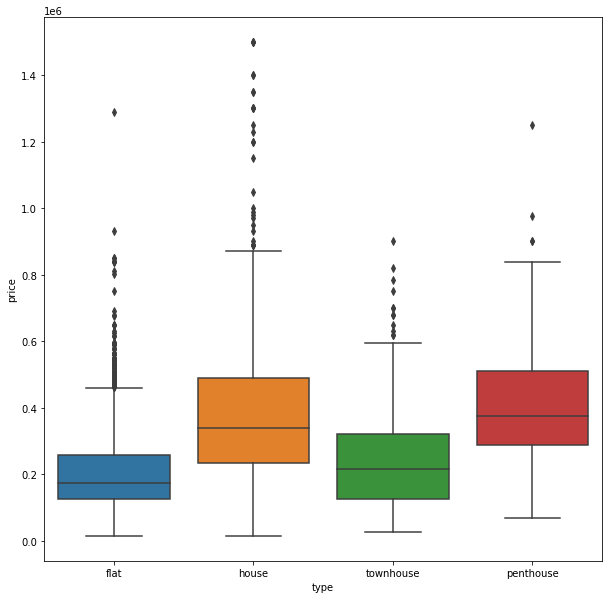

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax=ax, data=data, y='price', x='type')
plt.show()

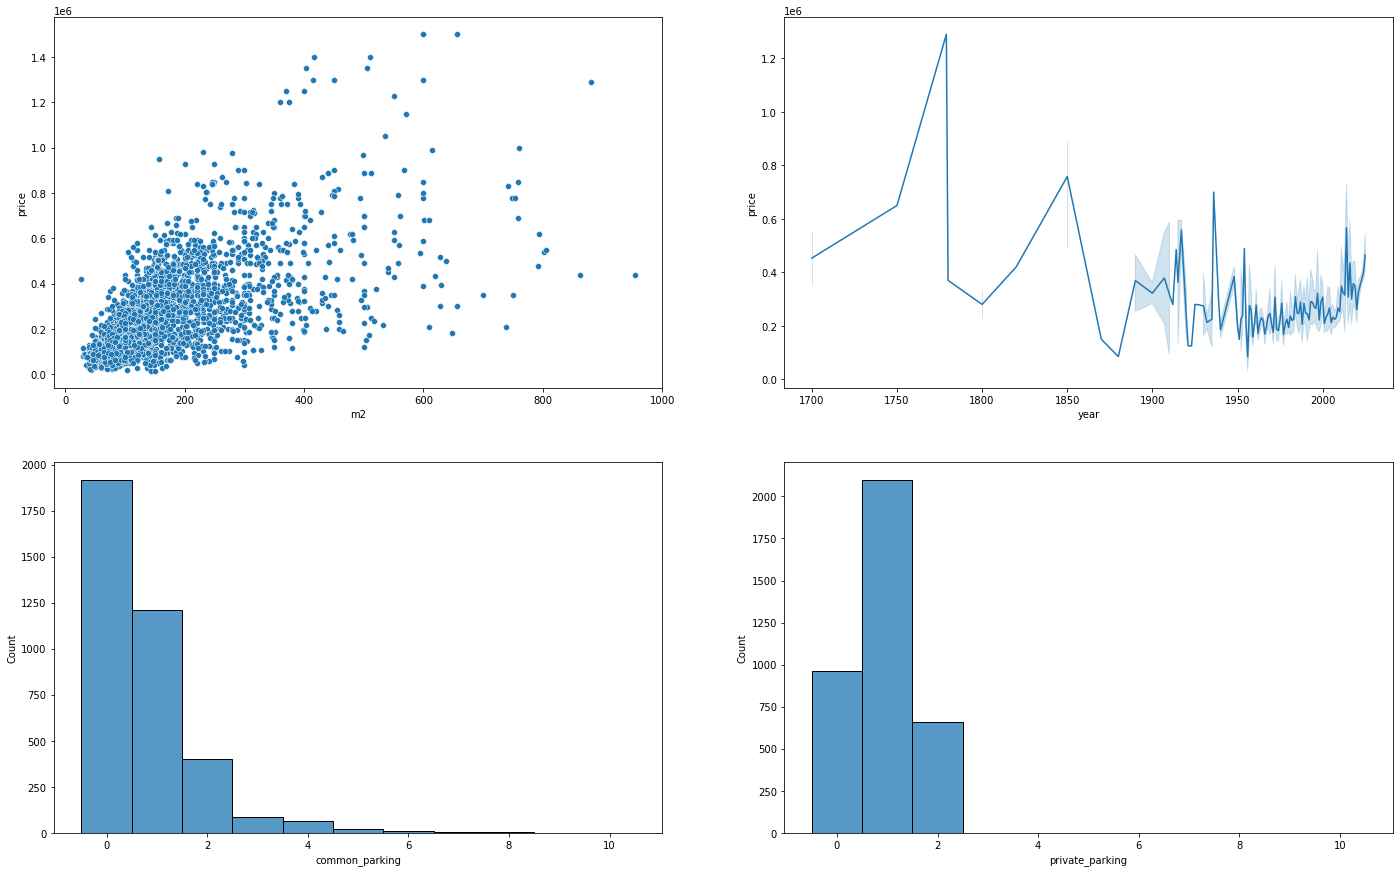

In [55]:
#plotting other useful visualizations
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
sns.scatterplot(ax=axs[0,0], data=data, x='m2', y='price')
sns.lineplot(ax=axs[0,1], data=data, x='year', y='price')
sns.histplot(ax=axs[1,0], data=data, stat='count', x='common_parking', binrange=(0,10), discrete=True)
sns.histplot(ax=axs[1,1], data=data, stat='count', x='private_parking', binrange=(0,10), discrete=True)

plt.show()

The final dataset that is going to be used is the following

In [56]:
data

,type,m2,bathrooms,bedrooms,private_parking,common_parking,elevator,private_garden,common_garden,balcony,autonomous_heating,heating_type,year,price,Lat,Long
0,flat,68.0,1,1,0,0,False,False,False,False,True,G,1970.0,82000.0,44.72697,10.99860
1,flat,92.0,2,2,1,1,False,False,False,False,True,G,1971.0,85000.0,44.72697,10.99860
2,flat,80.0,2,2,1,1,True,False,True,True,True,G,2007.0,133000.0,44.72697,10.99860
3,flat,110.0,2,2,1,1,False,False,True,True,True,G,1965.0,145000.0,44.72697,10.99860
4,flat,75.0,2,2,1,1,False,False,True,True,True,G,1998.0,128000.0,44.72697,10.99860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,flat,71.0,2,2,0,0,False,True,False,False,True,G,1992.0,96000.0,44.34566,10.99308
3715,flat,76.0,2,2,1,0,False,True,False,False,True,G,1994.0,90000.0,44.34566,10.99308
3716,flat,48.0,1,1,1,0,False,True,False,True,True,G,1980.0,39000.0,44.34566,10.99308
3717,townhouse,307.0,6,6,0,4,False,True,False,False,True,G,1975.0,185000.0,44.34566,10.99308


## Features transformation and selection
The aim now is to prepare the features for the model development phase.  
First step is the one-hot encoding of cathegorical variables.

In [57]:
cathegorical_columns = ['type','elevator','private_garden','common_garden','balcony','autonomous_heating','heating_type']

data = pd.get_dummies(data, columns=cathegorical_columns, dtype=int)

#half of the boolean one-hot-encoded columns must be deleted because they carry the same info
data.drop(columns=['elevator_False','private_garden_False','common_garden_False','balcony_False','autonomous_heating_False'],inplace=True)

#renaming features
data.rename(columns={'m2':'M2','bathrooms':'N_BATHR','bedrooms':'N_BEDR','private_parking':'N_PR_PARK','common_parking':'N_CM_PARK','year':'YEAR', 'price':'PRICE', 'Lat':'LAT', 'Long':'LONG', 
                     'type_flat':'FLAT','type_house':'HOUSE', 'type_penthouse':'PENTHOUSE','type_townhouse':'TOWNHOUSE','elevator_True':'ELEV','private_garden_True':'PR_GRDN','common_garden_True':'CM_GRDN',
                     'balcony_True':'BALCONY','autonomous_heating_True':'AUT_HEAT','heating_type_G':'GAS','heating_type_P':'HEAT_PUMP','heating_type_S':'SOLAR'},inplace=True)

In [58]:
data

,M2,N_BATHR,N_BEDR,N_PR_PARK,N_CM_PARK,YEAR,PRICE,LAT,LONG,FLAT,...,PENTHOUSE,TOWNHOUSE,ELEV,PR_GRDN,CM_GRDN,BALCONY,AUT_HEAT,GAS,HEAT_PUMP,SOLAR
0,68.0,1,1,0,0,1970.0,82000.0,44.72697,10.99860,1,...,0,0,0,0,0,0,1,1,0,0
1,92.0,2,2,1,1,1971.0,85000.0,44.72697,10.99860,1,...,0,0,0,0,0,0,1,1,0,0
2,80.0,2,2,1,1,2007.0,133000.0,44.72697,10.99860,1,...,0,0,1,0,1,1,1,1,0,0
3,110.0,2,2,1,1,1965.0,145000.0,44.72697,10.99860,1,...,0,0,0,0,1,1,1,1,0,0
4,75.0,2,2,1,1,1998.0,128000.0,44.72697,10.99860,1,...,0,0,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,71.0,2,2,0,0,1992.0,96000.0,44.34566,10.99308,1,...,0,0,0,1,0,0,1,1,0,0
3715,76.0,2,2,1,0,1994.0,90000.0,44.34566,10.99308,1,...,0,0,0,1,0,0,1,1,0,0
3716,48.0,1,1,1,0,1980.0,39000.0,44.34566,10.99308,1,...,0,0,0,1,0,1,1,1,0,0
3717,307.0,6,6,0,4,1975.0,185000.0,44.34566,10.99308,0,...,0,1,0,1,0,0,1,1,0,0


To select features appropriately, several technniques could be applied. In this case, a simple correlation analysis respect to the price feature is used, and just a few features with |corr|<10% are removed. Model regularization will further select features.  
\
Just to have some information in advance, a correlation matrix is plotted together with the correlation table of independent varibles respect to the price.

In [59]:
#correlation table
features = data.corr()['PRICE'].sort_values()
features

FLAT        -0.396235
GAS         -0.219629
CM_GRDN     -0.165197
LONG        -0.131027
BALCONY     -0.020004
TOWNHOUSE   -0.010904
LAT         -0.004630
AUT_HEAT     0.009464
ELEV         0.059071
YEAR         0.081481
HEAT_PUMP    0.099999
PENTHOUSE    0.179288
SOLAR        0.201771
N_CM_PARK    0.255808
N_PR_PARK    0.287409
PR_GRDN      0.337975
HOUSE        0.383361
N_BEDR       0.500512
N_BATHR      0.500512
M2           0.644796
PRICE        1.000000
Name: PRICE, dtype: float64

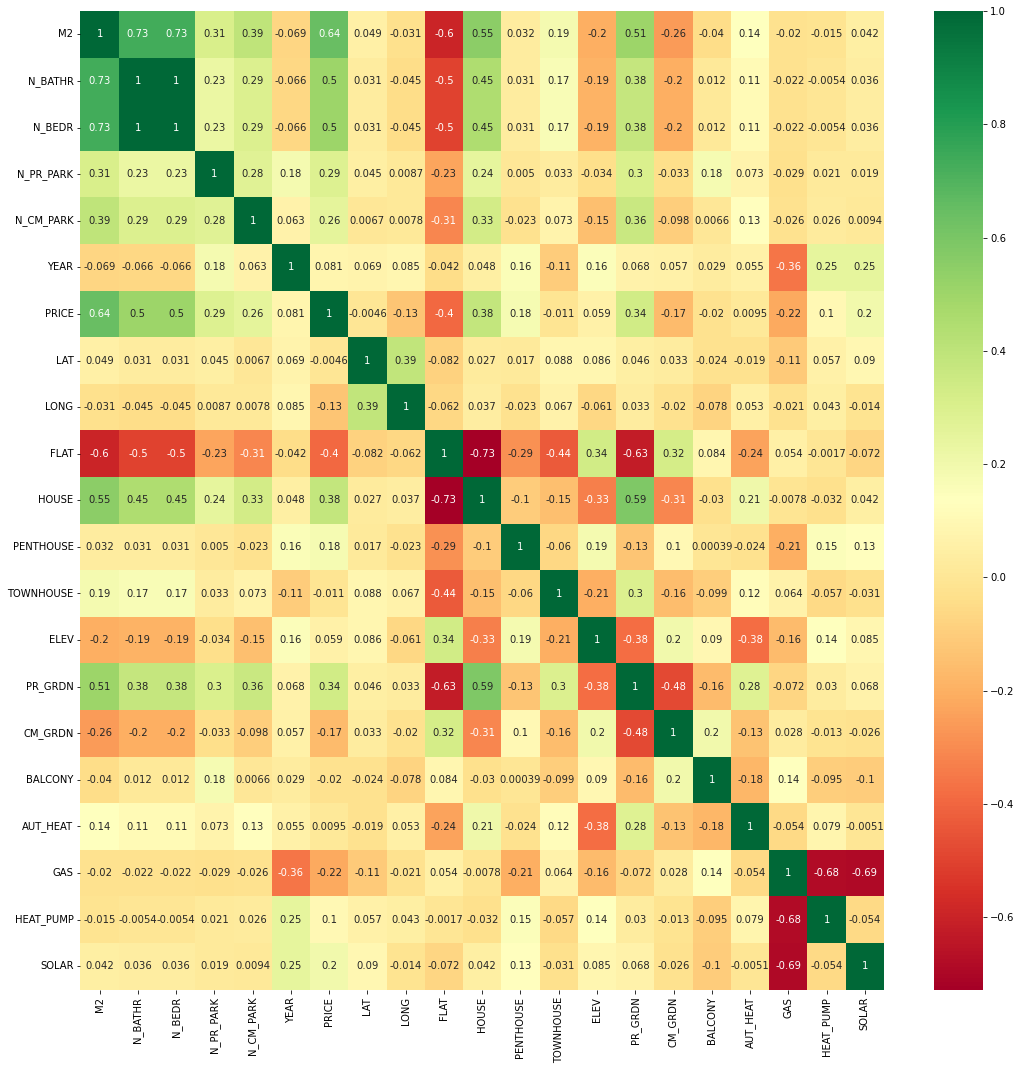

In [60]:
#correlation matrix
plt.figure(figsize=(18,18))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn')
plt.show()

In [61]:
#dropping columns with less than 10% correlation with sale price
X = data.drop(columns=['PRICE','BALCONY','TOWNHOUSE','LAT','AUT_HEAT','ELEV','YEAR','HEAT_PUMP'])
y = data['PRICE']

## Model development

#### Simple linear regression model

In [62]:
lm = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=18)

#scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#model training and scores
lm.fit(X_train,y_train)
lm_train_score = lm.score(X_train,y_train)
lm_test_score = lm.score(X_test,y_test)

print('Linear model R^2 score with training set is:',lm_train_score)
print('Linear model R^2 score with test set is:',lm_test_score)

print('sum of coefficients:',abs(lm.coef_).sum() )
print('number of coefficients not equal to 0:',(lm.coef_!=0).sum(),'out of',len(lm.coef_))


Linear model R^2 score with training set is: 0.5186649548554185
Linear model R^2 score with test set is: 0.4826637639885786
sum of coefficients: 309977.9584445808
number of coefficients not equal to 0: 13 out of 13


This model explains about 50% of the variance and is probably underfitting.  
\
Let's see the coefficients' values to understand the importance assigned to each feature.

In [63]:
coefficients = pd.DataFrame()
coefficients['Feature'] = X.columns
coefficients['Linear'] = lm.coef_
coefficients.sort_values(by='Linear',ascending=False)

,Feature,Linear
0,M2,103865.529359
6,FLAT,40756.215899
8,PENTHOUSE,39516.768411
7,HOUSE,30965.908274
3,N_PR_PARK,14602.496112
9,PR_GRDN,11328.815672
12,SOLAR,11036.713508
2,N_BEDR,4303.968047
1,N_BATHR,4303.968047
10,CM_GRDN,-2060.389631


#### Polinomial regression model
Adding degree 3 polinomial features in order to increase complexity in the model and increase reactivity as much as possible

In [64]:
lm_2 = LinearRegression()
pf = PolynomialFeatures(degree=3, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=18)

#creating polynomial features
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

#scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#model training and scores
lm_2.fit(X_train,y_train)
lm_train_score = lm_2.score(X_train,y_train)
lm_test_score = lm_2.score(X_test,y_test)

print('Linear model R^2 score with training set is:',lm_train_score)
print('Linear model R^2 score with test set is:',lm_test_score)


Linear model R^2 score with training set is: 0.7054940180620517
Linear model R^2 score with test set is: -4.9955529000466874e+19


In [65]:
print('sum of coefficients:',abs(lm_2.coef_).sum() )
print('number of coefficients not equal to 0:',(lm_2.coef_!=0).sum(),'out of',len(lm_2.coef_))

sum of coefficients: 6.526108236378973e+17
number of coefficients not equal to 0: 505 out of 559


Given the performace of training and testing pahases, this model with degree=3 polynomial features is clearly overfitting. Still, it can explain only 70% of the variance in the training set. This could mean that it is still biased and it could be interesting to check how testing performace changes by increasing the degree of polinomial features.

In [66]:
degrees = np.arange(2,8)
polynomial_scores = pd.DataFrame()
training_scores = []
testing_scores = []

for i in degrees:
    LM = LinearRegression()
    PF = PolynomialFeatures(degree=i, include_bias=False)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=18)

    #creating polynomial features
    X_train = PF.fit_transform(X_train)
    X_test = PF.transform(X_test)

    #scaling
    SS = StandardScaler()
    X_train = SS.fit_transform(X_train)
    X_test = SS.transform(X_test)

    #model training and scores
    LM.fit(X_train,y_train)
    training_scores.append(LM.score(X_train,y_train))
    testing_scores.append(LM.score(X_test,y_test))

polynomial_scores['degree'] = degrees
polynomial_scores['training score'] = training_scores
polynomial_scores['testing score'] = testing_scores

In [67]:
polynomial_scores

,degree,training score,testing score
0,2,0.610002,5.516534e-01
1,3,0.705494,-4.995553e+19
2,4,0.772534,-1.268079e+22
3,5,0.859876,-2.308986e+19
4,6,0.940890,-6.805318e+18
5,7,0.945112,-4.295129e+19


 
degree=6 seems to be the right choice if we want to maximize the model reactivity and keep the complexity as low as possible.  
\
Let's see if with regularization it is possible to reduce overfitting.

#### Ridge regression model

Riddge regression is used in order to have good results in a short computational time

In [68]:
pf = PolynomialFeatures(degree=5, include_bias=False)

alphas = [10, 100, 1000, 10000, 100000]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=18)

#creating polynomial features
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

#scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#model training and scores
score_df = pd.DataFrame()
training_score = []
test_score = []
best_score = 0

for alpha in alphas:
    RR = Ridge(alpha=alpha)
    RR.fit(X_train,y_train)

    training_score.append(r2_score(y_train,RR.predict(X_train)))
    test_score.append(r2_score(y_test,RR.predict(X_test)))

    if r2_score(y_test,RR.predict(X_test)) > best_score:
        best_RR = RR
        best_score = r2_score(y_test,RR.predict(X_test))
        best_alpha = alpha

score_df['Alpha'] = alphas
score_df['Training r2 scores'] = training_score
score_df['Test r2 scores'] = test_score

In [69]:
score_df

,Alpha,Training r2 scores,Test r2 scores
0,10,0.699851,0.419484
1,100,0.673829,0.506904
2,1000,0.642715,0.543295
3,10000,0.591687,0.526661
4,100000,0.493739,0.431077


In [76]:
print('Best Ridge regression model alpha value:',best_alpha)
print('training r2 performance:', float(score_df[score_df['Alpha']==best_alpha]['Training r2 scores'].values))
print('testing r2 performance:', float(score_df[score_df['Alpha']==best_alpha]['Test r2 scores'].values))
print('testing RMSE performance:', np.sqrt(mean_squared_error(y_test,RR.predict(X_test))))
print('sum of coefficients:',abs(best_RR.coef_).sum() )
print('number of coefficients not equal to 0:',(best_RR.coef_!=0).sum(),'out of',len(best_RR.coef_))

Best Ridge regression model alpha value: 1000
training r2 performance: 0.6236960686659634
testing r2 performance: 0.5354858628777038
testing RMSE performance: 128191.53019118402
sum of coefficients: 2219592.1916606436
number of coefficients not equal to 0: 6016 out of 8567


#### LASSO regression model
Applying Lasso regression to try to simplify the polynomial model and reduce the number of used features.

In [71]:
pf = PolynomialFeatures(degree=5, include_bias=False)
alphas = [10, 100, 1000, 10000, 100000]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=18)

#creating polynomial features
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

#scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#model training and scores
score_df = pd.DataFrame()
training_score = []
test_score = []
best_score = 0

for alpha in alphas:
    LL = Lasso(alpha=alpha, max_iter=5e4)
    LL.fit(X_train,y_train)

    training_score.append(r2_score(y_train,LL.predict(X_train)))
    test_score.append(r2_score(y_test,LL.predict(X_test)))

    if r2_score(y_test,LL.predict(X_test)) > best_score:
        best_LL = LL
        best_score = r2_score(y_test,LL.predict(X_test))
        best_alpha = alpha

score_df['Alpha'] = alphas
score_df['Training r2 scores'] = training_score
score_df['Test r2 scores'] = test_score

/Users/jacopoferreri/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1307069466575.041, tolerance: 8065605848.889497
  model = cd_fast.enet_coordinate_descent(


In [72]:
score_df

,Alpha,Training r2 scores,Test r2 scores
0,10,0.738770,-0.012875
1,100,0.692224,0.511609
2,1000,0.623696,0.535486
3,10000,0.522808,0.497625
4,100000,0.098868,0.103650


In [75]:
print('Best Lasso regression model alpha value:',best_alpha)
print('training r2 performance:', float(score_df[score_df['Alpha']==best_alpha]['Training r2 scores'].values))
print('testing r2 performance:', float(score_df[score_df['Alpha']==best_alpha]['Test r2 scores'].values))
print('testing RMSE performance:', np.sqrt(mean_squared_error(y_test,LL.predict(X_test))))
print('sum of coefficients:',abs(best_LL.coef_).sum() )
print('number of coefficients not equal to 0:',(best_LL.coef_!=0).sum(),'out of',len(best_LL.coef_))

Best Lasso regression model alpha value: 1000
training r2 performance: 0.6236960686659634
testing r2 performance: 0.5354858628777038
testing RMSE performance: 160905.70642888747
sum of coefficients: 727684.1697139615
number of coefficients not equal to 0: 215 out of 8567


## Results summary and conclusions

The aim of this research was trying to understand if, solely with data pubblished on online house sale websites, it is possible to develop a ML regression capable of accurate predictsions in terms of sale price. Several regression models were developed, in particular a polynomial model of degree=5 that later fine-tuned with both Ridge and Lasso regression to adress overfitting.  
\
In numbers it was found that:
1. even with an overfitting polynomial model of high degree, it was difficult to cover up to 95% of the variance in the training set.
2. a model of degree 5 was chosen to try to increase the explained variance while still keeping the feature number to a reasonable value considering a total sample of about 3700.
3. best Ridge regression model achieved an r^2 score of 0.543 on unseen data ($\alpha$ = 1000). 
4. best LASSO regression model achieved an r^2 score of 0.535 on unseen data ($\alpha$ = 1000).  

In conclusion, the best model that was developed is the Ridge regression model, with $\alpha$ of 1000 but it is still not enough performing to only rely on house sales data websites to predict the house sale price properly.
So no, it is not possible to just use data available on the house sales websites and overlook some other important charcteristics that one usually considers while pricing a house. Such additional features could for instance be the house conditions (to be restored, just restored, good, ect.) and neighborhood quality.  

## Possible further improvements


- The used dataset lacks particularly important features like the house condition and neighborhood overall quality. To improve the model it would be useful to collect this kind of information and retrain the models to check for improvements;
- feature engineering part could be enhanced to get an even better tuned model;
- To be sure about model parameters cross-validation for model training could be used.
- Grid search could be applied with a focus of $\alpha$ parameters around 1000 for both models